In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tqdm

In [2]:
class KMeans:
    def __init__(self, k, init='random', n_guess=10, max_iter=300, epsilon=1e-2):
        self.k_clusters = k
        self.init = init
        self.n_guess = n_guess
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.cluster_centers = None

    def _init_cluster_centers(self, xs):
        cc = np.array([])
        if self.init == 'random':
            idx = np.random.choice(range(xs.shape[0]), self.k_clusters, replace=False)
            cc = xs[idx]
        elif self.init == 'k-means++':
            init_idx = np.random.choice(range(xs.shape[0]))
            cc = np.array([init_idx], dtype=int)
            while len(cc) < self.k_clusters:
                squared_distances = np.linalg.norm(
                    xs[:, np.newaxis] - xs[cc][np.newaxis], axis=-1
                ).min(axis=-1) ** 2
                total_dis = squared_distances.sum()
                prob = squared_distances / total_dis
                cc = np.append(cc, np.random.choice(range(xs.shape[0]), p=prob))
            cc = xs[cc]
        return cc

    def predict(self, xs, cluster_centers=None):
        cluster_centers = self.cluster_centers if cluster_centers is None else cluster_centers

        # xs.shape: (n, ch), cluster_centers.shape: (k, ch)
        return np.linalg.norm(xs[:, np.newaxis] - cluster_centers[np.newaxis],
                              axis=-1).argmin(axis=-1)

    def score(self, cluster_centers, xs):
        distance = np.linalg.norm(
            xs[:, np.newaxis] - cluster_centers[np.newaxis], axis=-1
        ).min(axis=-1).sum()
        return distance

    def _update_center(self, cluster_centers, xs):
        idx = self.predict(xs, cluster_centers)
        new_centers = np.array([xs[idx == i].mean(axis=0) for i in range(self.k_clusters)])
        return new_centers

    def fit(self, xs):
        best, best_cc = -1, None
        for i in range(self.n_guess):
            cluster_centers = self._fit_single_run(xs, i)
            score = self.score(cluster_centers, xs)
            if best == -1 or score < best:
                best, best_cc = score, cluster_centers
        self.cluster_centers = best_cc
        return self

    def _fit_single_run(self, xs, rnd=0):
        cluster_centers = self._init_cluster_centers(xs)
        for _ in tqdm.trange(self.max_iter, desc=f'Round {rnd + 1}: '):
            new_cc = self._update_center(cluster_centers, xs)
            change = np.linalg.norm(new_cc - cluster_centers, axis=-1)
            converge = (change < self.epsilon).all()
            if converge:
                break
            cluster_centers = new_cc
        return cluster_centers


In [3]:
image = cv2.imread('2-image.jpg')
image

array([[[172, 153, 150],
        [160, 141, 138],
        [168, 149, 146],
        ...,
        [168, 151, 148],
        [167, 150, 147],
        [167, 150, 147]],

       [[174, 155, 152],
        [180, 161, 158],
        [184, 165, 162],
        ...,
        [168, 151, 148],
        [167, 150, 147],
        [167, 150, 147]],

       [[166, 147, 144],
        [178, 159, 156],
        [138, 119, 116],
        ...,
        [168, 152, 146],
        [168, 152, 146],
        [167, 151, 145]],

       ...,

       [[ 28,  20,   7],
        [ 28,  20,   7],
        [ 28,  20,   7],
        ...,
        [ 30,  24,  13],
        [ 30,  24,  13],
        [ 30,  24,  13]],

       [[ 28,  20,   7],
        [ 28,  20,   7],
        [ 28,  20,   7],
        ...,
        [ 30,  24,  13],
        [ 30,  24,  13],
        [ 30,  24,  13]],

       [[ 28,  20,   7],
        [ 28,  20,   7],
        [ 28,  20,   7],
        ...,
        [ 30,  24,  13],
        [ 30,  24,  13],
        [ 30,  24,  13]]

In [4]:
flatten_img = image.reshape((-1, 3))
flatten_img

array([[172, 153, 150],
       [160, 141, 138],
       [168, 149, 146],
       ...,
       [ 30,  24,  13],
       [ 30,  24,  13],
       [ 30,  24,  13]], dtype=uint8)

In [11]:
import time
start = time.time()
kmeans = KMeans(10, n_guess=50, max_iter=100, epsilon=1)
kmeans.fit(flatten_img)
print(f'{time.time() - start} secs')

Round 22:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_17540\328693762.py:43: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([xs[idx == i].mean(axis=0) for i in range(self.k_clusters)])
D:\Pipenv\MLCourse-1D2fA_m1\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
Round 50:  13%|█▎        | 13/100 [00:01<00:07, 11.09it/s]


126.07549977302551 secs


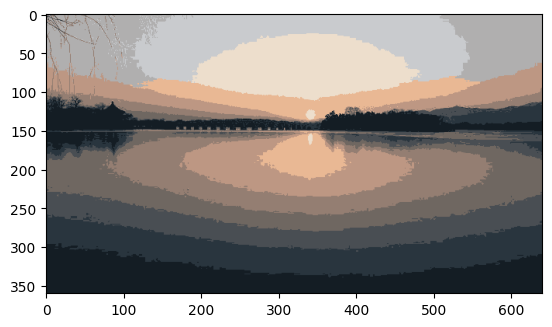

In [6]:
quantized_image = kmeans.cluster_centers[kmeans.predict(flatten_img)]
quantized_image = quantized_image.reshape(image.shape).astype(np.uint8)

plt.imshow(quantized_image[..., ::-1])